In [2]:
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision import datasets, models
from torchvision.transforms import transforms
from torchsummary import summary
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Function for setting the seed - used from Lab 7 - ResNet code.
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42)
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Choose GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

BATCH_SIZE = 64

# Get class names for CIFAR-100
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

kwargs = {'num_workers': 2, 'pin_memory': True} if torch.cuda.is_available() else {}


cuda


In [4]:
# Define an initial training dataset from cifar100 that will be used to determine the mean/std
set_seed(42)

initial_train_data = datasets.CIFAR100('data', train=True, download=True, transform=transforms.Compose([
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor()
                                   ]))
initial_train_loader = DataLoader(initial_train_data, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 169M/169M [00:13<00:00, 12.2MB/s]


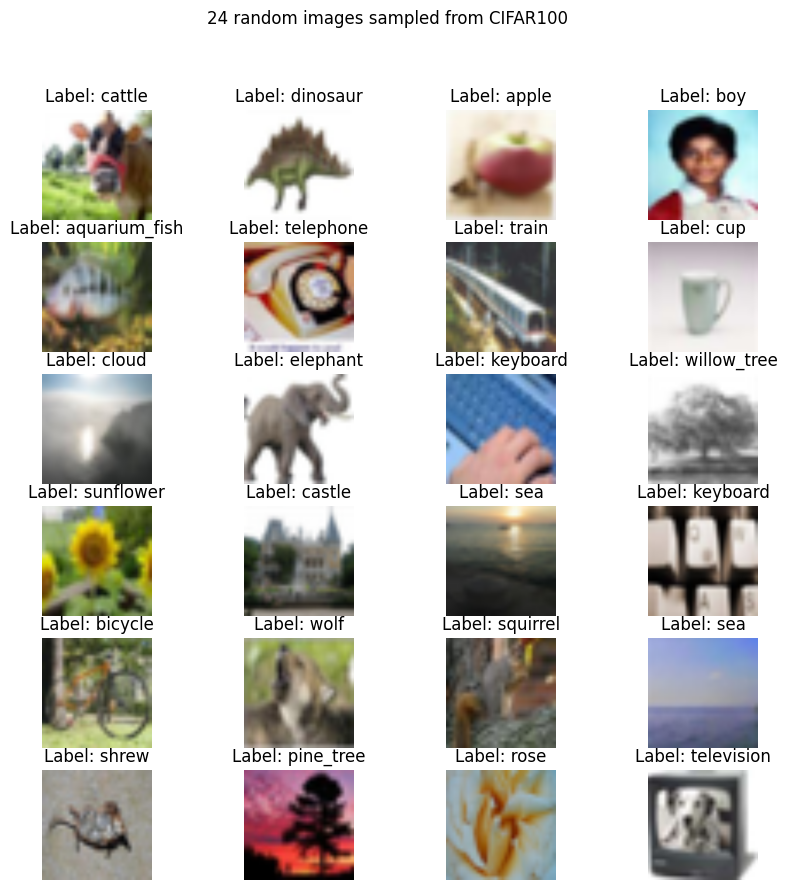

In [5]:
fig, ax = plt.subplots(6, 4, figsize=(10,10))

# Plot some of the training images for reference of the dataset
for i in range(24):
  img, label = initial_train_data[i]
  img = img.permute(1,2,0).numpy()

  fig.suptitle("24 random images sampled from CIFAR100")
  ax[i // 4, i % 4].set_title(f"Label: {class_names[label]}")
  ax[i // 4, i % 4].imshow(img)
  ax[i // 4, i % 4].axis('off')

In [8]:
# Find the mean/std from the training data for normalization
mean = (initial_train_data.data / 255.0).mean(axis=(0,1,2))
std = (initial_train_data.data / 255.0).std(axis=(0,1,2))
print("Mean: ", mean, "\nStd: ", std)

Mean:  [0.50707516 0.48654887 0.44091784] 
Std:  [0.26733429 0.25643846 0.27615047]


In [9]:
# Define data augmentation transforms for the dataset and create new training data using the mean and std calculated

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.RandomCrop(size=(224, 224), padding=8),
    transforms.Normalize(mean=mean, std=std)]
)

# For baseline ResNet, no transforms.
basic_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Create datasets for training and test sets.
train = datasets.CIFAR100('data', train=True, download=False, transform=data_transforms)
val = datasets.CIFAR100('data', train=True, download=True, transform=basic_transforms)

# Perform an 90/10 split to create training and validation datasets
set_seed(42)
train_data, _ = random_split(train, [45000, 5000])
set_seed(42)
_, val_data = random_split(val, [45000, 5000])

test_data = datasets.CIFAR100('data', train=False, download=True, transform=basic_transforms)

train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, **kwargs)
val_loader = DataLoader(val_data, shuffle=False, batch_size=BATCH_SIZE, **kwargs)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, **kwargs)

print(f"Training dataset: {len(train_data)} images, Validation dataset: {len(val_data)} images, Test dataset: {len(test_data)} images")

Training dataset: 45000 images, Validation dataset: 5000 images, Test dataset: 10000 images


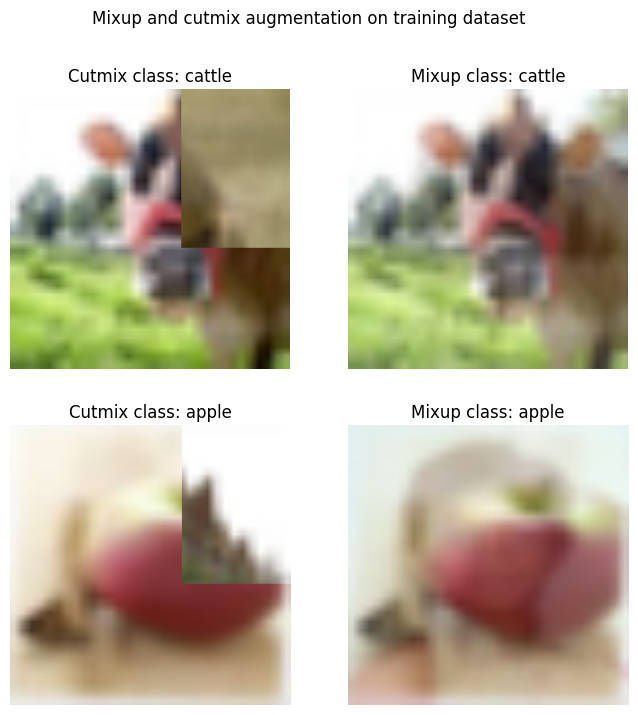

In [10]:
"""

This section of code was copied from CutMix/MixUp tutorial supplied by PyTorch Documentation guides
https://docs.pytorch.org/vision/main/auto_examples/transforms/plot_cutmix_mixup.html

The guide is also referenced in the report.
"""

from torchvision.transforms import v2
cutmix = v2.CutMix(num_classes=100)
mixup = v2.MixUp(num_classes=100)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

set_seed(42)
imgs, labels = next(iter(initial_train_loader))

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle("Mixup and cutmix augmentation on training dataset")

# Apply on the whole batch
cutmix_imgs, cutmix_labels = cutmix(imgs, labels)
mixup_imgs, mixup_labels = mixup(imgs, labels)

# Plot some examples of cutmix/mixup augmentations on the training data
for i in range(4):
    if i % 2 == 0:
        img = cutmix_imgs[i].permute(1,2,0)
        title = "Cutmix class: " + class_names[cutmix_labels[i].argmax()]
    else:
        img = mixup_imgs[i].permute(1,2,0)
        title = "Mixup class: " + class_names[mixup_labels[i].argmax()]

    ax[i // 2, i % 2].imshow(img)
    ax[i // 2, i % 2].set_title(title)
    ax[i // 2, i % 2].axis("off")

plt.show()


In [11]:
class TrainModel():

  def __init__(self, model, criterion, optim, device, cutmix_bool=False):
    """
    This class has three functions to train, validate and test the model,
    returning the accuracy and loss after each batch from the loader.

    Args:
      model: model used in classification
      criterion: the loss function
      optim: the optimizer used for updating weights
      device: either Cuda or CPU depending on availability
    """

    self.model = model
    self.criterion = criterion
    self.optim = optim
    self.device = device
    self.cutmix = cutmix_bool

  def train(self, train_loader):
    # Sets the model to training mode
    model = self.model.train()

    correct = 0
    running_loss = 0

    for i, (data, label) in enumerate(train_loader):

      # Conditional statement used if implementing cutmix augmentation on the data
      if self.cutmix:
          data, label = cutmix_or_mixup(data, label)

      data, label = data.to(self.device), label.to(self.device) # Send to GPU if available


      self.optim.zero_grad()
      pred = model(data)

      # Compute the loss
      loss = self.criterion(pred, label)
      loss.backward()
      self.optim.step()

      # Used if cutmix augmentation is being used on the training set, then the
      # label output changes to shape (batch_size, num_classes)

      if label.ndimension() == 2:
            true_labels = torch.argmax(label, dim=1)
      else:
            true_labels = label

      # Update statistics for training
      running_loss += loss.item()
      _, predicted = torch.max(pred, 1)
      correct += (predicted == true_labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    avg_acc = 100 * (correct / len(train_loader.dataset))

    return avg_loss, avg_acc

  def val(self, val_loader):
    """
    This method is called in the main training loop to evaluate the model on the
    validation dataset. Early stopping and hyperparameter tuning uses the loss from
    this function to update any parameters.
    """
    # Sets the model to eval mode so the weights aren't updated
    model = self.model.eval()
    running_loss = 0
    correct = 0

    with torch.no_grad():

      for (data, label) in val_loader:
        # Send to GPU
        data, label = data.to(self.device), label.to(self.device)

        preds = model(data)
        # Compute the loss
        loss = self.criterion(preds, label)

        # Update statistics for training
        running_loss += loss.item()
        _, predicted = torch.max(preds, 1)
        correct += (predicted == label).sum().item()

      val_loss = running_loss / len(val_loader)
      val_acc = 100 * (correct / len(val_loader.dataset))

    return val_loss, val_acc

  def test(self, test_loader, model, visualize=False, num_images=4):
    """
    This method is called after training is complete to test the performance
    of the best model on the unseen test dataset.

    If wanted, visualize the results of the test dataset on x images.
    """

    model = model.eval()
    total = 0
    correct = 0
    images_seen = 0

    if visualize:
      fig = plt.figure(figsize=(10, 10))

    with torch.no_grad():
      for (data, label) in test_loader:
        data, label = data.to(self.device), label.to(self.device)

        preds = model(data)
        _, predicted = torch.max(preds, 1)
        correct += (predicted == label).sum().item()
        total += label.size(0)


        if visualize:
          for i in range(data.size()[0]):
            images_seen += 1

            ax = plt.subplot(num_images // 2, 2, images_seen)
            ax.axis('off')
            ax.set_title(f'Predicted: {class_names[predicted[i]]} Label: {class_names[label[i]]}')

            img = self._unnormalize(data[i].cpu())
            img = img.permute(1, 2, 0).clamp(0,1)

            # Convert tensor to numpy array before calling astype
            pil_img = Image.fromarray((img * 255).numpy().astype(np.uint8))
            sharp = pil_img.filter(ImageFilter.SHARPEN)


            plt.imshow(sharp, interpolation='none')

            if images_seen == num_images:
                return
        else:
          continue

      acc = 100 * (correct/total)
    return acc

  def _unnormalize(self, img):
    """
    This method is called internally to denormalize test images for
    plotting in pyplot.
    """
    img = img * torch.tensor(std).view(3,1,1) + torch.tensor(mean).view(3,1,1)
    return img

In [12]:
"""
This class is used to stop the training loop if there is minimal improvement
of the model on the validation dataset, which is used to prevent overfitting.

The tutorial and help for this code came from:
https://www.geeksforgeeks.org/deep-learning/how-to-handle-overfitting-in-pytorch-models-using-early-stopping/
"""

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)


In [13]:
from torchvision.models import ResNet18_Weights

# Define ResNet model with pretrained weights on ImageNet. Define the fully connected layer for ResNet that
# will be trained on CIFAR100
resnet = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = resnet.fc.in_features

# Create a new fc layer.
fc_network = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 100)
)
resnet.fc = fc_network

# 3. Freeze convolutional layers
for param in resnet.parameters():
    param.requires_grad = False

# Unfreeze the last layer to adapt to CIFAR100
for param in resnet.layer4.parameters():
    param.requires_grad = True

for param in resnet.fc.parameters():
    param.requires_grad = True


resnet = resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 235MB/s]


In [14]:
fc_network = fc_network.to(device)
summary(fc_network, (512,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         131,328
              ReLU-2                  [-1, 256]               0
           Dropout-3                  [-1, 256]               0
            Linear-4                  [-1, 100]          25,700
Total params: 157,028
Trainable params: 157,028
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.60
Estimated Total Size (MB): 0.61
----------------------------------------------------------------


In [16]:
"""
This learning rate optimization function was taken from the COMP338
Lab 08 Fashion MNIST Classification tutorial. It is used to find the best initial
learning rate for the model to begin its training at.

The best results from this model was 2.5e-5 and some of these other outputs were
not as good in the training process.
"""

def loop_loader(data_loader):
    while True:
        for elem in data_loader:
            yield elem

def find_lr(model, train_loader, init_lr, max_lr, steps, n_batch_per_step=30):
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)
    current_lr = init_lr
    best_lr = current_lr
    best_loss = float('inf')
    lr_step = (max_lr - init_lr) / steps
    cuda = torch.cuda.is_available()
    loader = loop_loader(train_loader)
    criterion = nn.CrossEntropyLoss()

    for i in range(steps):
        mean_loss = 0
        n_seen_samples = 0
        for j, (data, target) in enumerate(loader):
            if j > n_batch_per_step:
                break
            optimizer.zero_grad()
            if cuda:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            mean_loss += loss.item() * data.shape[0]
            n_seen_samples += data.shape[0]
            optimizer.step()

        mean_loss /= n_seen_samples
        print('Step %i, current LR: %f, loss %f' % (i, current_lr, mean_loss))

        if np.isnan(mean_loss) or mean_loss > best_loss * 4:
            return best_lr / 4

        if mean_loss < best_loss:
            best_loss = mean_loss
            best_lr = current_lr

        current_lr += lr_step
        optimizer.param_groups[0]['lr'] = current_lr

    return best_lr / 4

In [ ]:
# Finds the optimal learning rate for the initial rate in the training loop
lr = find_lr(resnet, train_loader, 1e-5, 1, 50, 30)
print('Best LR', lr)

Step 0, current LR: 0.000010, loss 4.679508
Step 1, current LR: 0.020010, loss 4.707698
Step 2, current LR: 0.040010, loss 4.603432
Step 3, current LR: 0.060009, loss 4.619663
Step 4, current LR: 0.080009, loss 4.631752
Step 5, current LR: 0.100009, loss 4.632932
Step 6, current LR: 0.120009, loss 4.643249
Step 7, current LR: 0.140009, loss 4.642764
Step 8, current LR: 0.160008, loss 4.655058
Step 9, current LR: 0.180008, loss 4.664691
Step 10, current LR: 0.200008, loss 4.659905
Step 11, current LR: 0.220008, loss 4.679871
Step 12, current LR: 0.240008, loss 4.688403
Step 13, current LR: 0.260007, loss 4.687147
Step 14, current LR: 0.280007, loss 4.681105
Step 15, current LR: 0.300007, loss 4.690146
Step 16, current LR: 0.320007, loss 4.702263
Step 17, current LR: 0.340007, loss 4.710733
Step 18, current LR: 0.360006, loss 4.731322
Step 19, current LR: 0.380006, loss 4.745187
Step 20, current LR: 0.400006, loss 4.733382
Step 21, current LR: 0.420006, loss 4.719374
Step 22, current LR:

In [17]:
# Define new optimizer and learning rate scheduler for ResNet
optim = torch.optim.Adam(resnet.parameters(), lr=0.00025)
criterion = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=7, delta=0.01)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=0.1, patience=2)
resnet_train = TrainModel(resnet, criterion, optim, device, cutmix_bool=True)


In [ ]:
# Initialize model
epochs = 50

# Create variables to store loss/accuracy over training period
training_loss = []
training_acc = []

valid_loss = []
valid_acc = []

learning_rates = []

for epoch in range(epochs):
  print(f'\nEpoch {epoch + 1}/{epochs}')
  print('-' * 10)

  # Get predictions from train and validation loops
  train_loss, train_acc = resnet_train.train(train_loader)
  val_loss, val_acc = resnet_train.val(val_loader)

  print(f"Training: Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f} %")
  print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f} %")


  training_loss.append(train_loss)
  training_acc.append(train_acc)
  valid_loss.append(val_loss)
  valid_acc.append(val_acc)

  early_stopping(val_loss, resnet)

  if early_stopping.early_stop:
    print("Early stopping condition reached. Terminating training...")
    break

  #Step the scheduler based on minimizing val loss
  scheduler.step(val_loss)

  #Add the learning rate to the list
  learning_rates.append(optim.param_groups[0]['lr'])



Epoch 1/50
----------
Training: Loss: 3.6565, Accuracy: 22.40 %
Validation: Loss: 1.8023, Accuracy: 53.50 %

Epoch 2/50
----------
Training: Loss: 3.1191, Accuracy: 36.71 %
Validation: Loss: 1.5590, Accuracy: 59.10 %

Epoch 3/50
----------
Training: Loss: 2.9786, Accuracy: 41.58 %
Validation: Loss: 1.4527, Accuracy: 62.78 %

Epoch 4/50
----------
Training: Loss: 2.9091, Accuracy: 43.81 %
Validation: Loss: 1.3098, Accuracy: 65.64 %

Epoch 5/50
----------
Training: Loss: 2.8125, Accuracy: 46.80 %
Validation: Loss: 1.2450, Accuracy: 67.12 %

Epoch 6/50
----------
Training: Loss: 2.7706, Accuracy: 48.46 %
Validation: Loss: 1.2582, Accuracy: 67.32 %

Epoch 7/50
----------
Training: Loss: 2.7039, Accuracy: 50.61 %
Validation: Loss: 1.1727, Accuracy: 69.42 %

Epoch 8/50
----------
Training: Loss: 2.6929, Accuracy: 51.53 %
Validation: Loss: 1.1355, Accuracy: 69.88 %

Epoch 9/50
----------
Training: Loss: 2.6824, Accuracy: 51.64 %
Validation: Loss: 1.1162, Accuracy: 70.46 %

Epoch 10/50
------

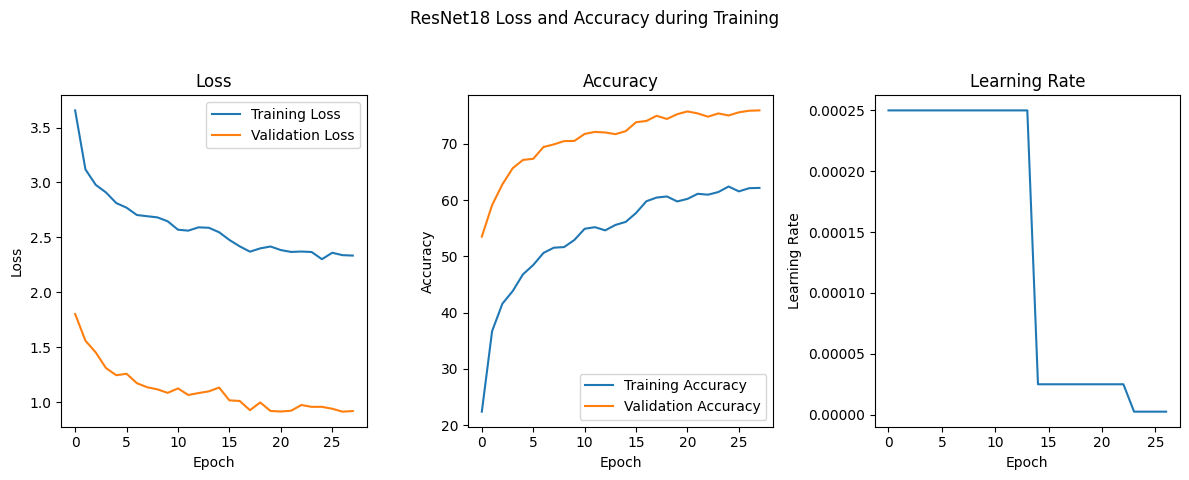

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

fig.suptitle("ResNet18 Loss and Accuracy during Training")

# Plot Training and Testing Loss
ax[0].plot(training_loss, label='Training Loss')
ax[0].plot(valid_loss, label='Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss')
ax[0].legend()

# Plot Training and Testing Accuracy
ax[1].plot(training_acc, label='Training Accuracy')
ax[1].plot(valid_acc, label='Validation Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()

ax[2].plot(learning_rates, label='Learning Rate')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Learning Rate')
ax[2].set_title('Learning Rate')


plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
plt.show()

In [ ]:
# Save the best weights of the model
early_stopping.load_best_model(resnet)
torch.save(resnet.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Models/b64_best.pt")

Test Accuracy: 75.72 %


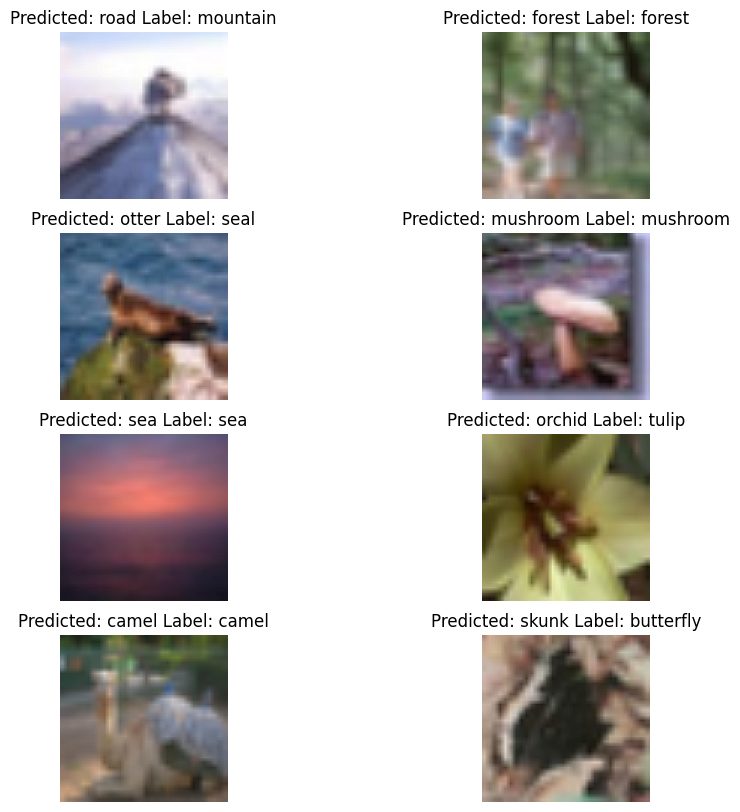

In [18]:
# Test the best model on the unseen test dataset
resnet.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Models/b64_best.pt"))
tester = TrainModel(resnet, criterion, optim, device, cutmix_bool=False)
acc = tester.test(test_loader, resnet)
print(f"Test Accuracy: {acc:.2f} %")

# Plot 8 images with the class predictions from the model
tester.test(test_loader, resnet, visualize=True, num_images=8)


